# **A2: Community Structure of Complex Networks**

* **Authors:** Sofía González Estrada, Ravneet-Rahul Sandhu Singh
* **Date:** November 23, 2025

In [42]:
import glob
import io
import os
import random
import sys
from collections import Counter, defaultdict

import graph_tool.all as gt
import infomap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from PIL import Image, ImageOps
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

In [43]:
plt.style.use("../config/matplotlib/mhedas.mplstyle")

## **1. Load Data**

Nodes: 832
Edges: 86528
Connected: True


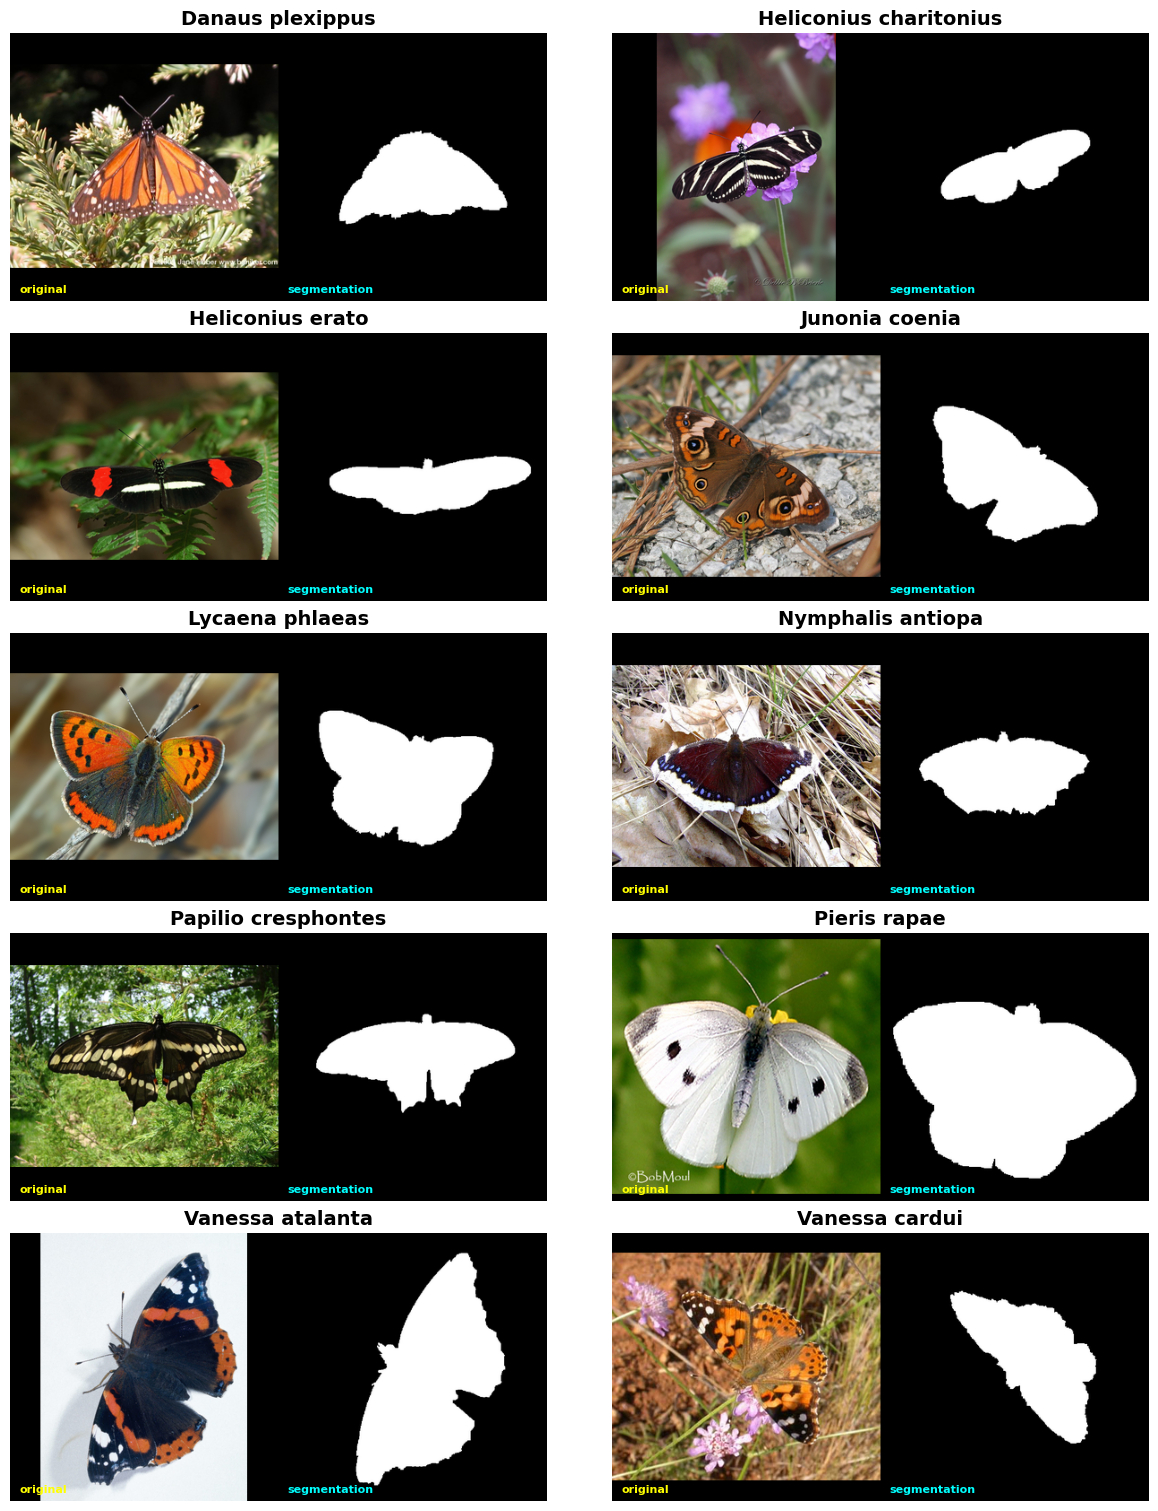

In [44]:
# Load the edge weights
df_weights = pd.read_csv("../data/leedsbutterfly/butterfly_weights.tsv", sep="\t")

# Create the graph from the edge list
G = nx.from_pandas_edgelist(
    df_weights,
    source="# NodeID1",
    target="NodeID2",
    edge_attr="Image similarity weight",
)

# Load the node labels
df_labels = pd.read_csv("../data/leedsbutterfly/butterfly_labels.tsv", sep="\t")

# Create a dictionary mapping Node ID to Species
labels_dict = pd.Series(
    df_labels["Species"].values, index=df_labels["# Node_ID"]
).to_dict()

# Apply the labels to the graph nodes
nx.set_node_attributes(G, labels_dict, name="Species")

print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Connected: {nx.is_connected(G)}")

# Define paths
data_root = "../data/leedsbutterfly"
img_dir = os.path.join(data_root, "images")
seg_dir = os.path.join(data_root, "segmentations")
target_size = (300, 300)

# Species mapping
species_names = {
    1: "Danaus plexippus",
    2: "Heliconius charitonius",
    3: "Heliconius erato",
    4: "Junonia coenia",
    5: "Lycaena phlaeas",
    6: "Nymphalis antiopa",
    7: "Papilio cresphontes",
    8: "Pieris rapae",
    9: "Vanessa atalanta",
    10: "Vanessa cardui",
}

# Scan for valid pairs
valid_pairs = {}
image_files = glob.glob(os.path.join(img_dir, "*.png"))

# Get filenames
for img_path in image_files:
    # Extract category ID from filename
    filename = os.path.basename(img_path)

    # Direct conversion assuming format is correct
    cat_id = int(filename[:3])

    # Corresponding segmentation path
    seg_filename = filename.replace(".png", "_seg0.png")
    seg_path = os.path.join(seg_dir, seg_filename)

    # Check if segmentation file exists
    if os.path.exists(seg_path):
        if cat_id not in valid_pairs:
            valid_pairs[cat_id] = []
        valid_pairs[cat_id].append((img_path, seg_path))

# Select categories to plot
available_cats = sorted(valid_pairs.keys())

# Plot if previous steps were successful
if available_cats:
    # Use all available categories
    cats_to_plot = available_cats

    # Define plot
    fig, axes = plt.subplots(5, 2, figsize=(12, 15), layout="constrained")    
    axes = axes.flatten()

    # Plot each species
    for i, ax in enumerate(axes):
        cat_id = cats_to_plot[i]
        img_path, seg_path = random.choice(valid_pairs[cat_id])

        # Load images
        img_pil = Image.open(img_path).convert("RGB")
        seg_pil = Image.open(seg_path)

        # Process mask to rgb
        seg_np = np.array(seg_pil)
        binary_mask = np.zeros_like(seg_np, dtype=np.uint8)
        binary_mask[(seg_np == 1) | (seg_np == 3)] = 255
        mask_pil = Image.fromarray(np.stack([binary_mask] * 3, axis=-1), "RGB")

        # Resize image
        img_pil.thumbnail(target_size, Image.Resampling.LANCZOS)
        new_img = Image.new("RGB", target_size, (0, 0, 0))
        new_img.paste(
            img_pil,
            (
                (target_size[0] - img_pil.size[0]) // 2,
                (target_size[1] - img_pil.size[1]) // 2,
            ),
        )

        # Resize mask
        mask_pil.thumbnail(target_size, Image.Resampling.LANCZOS)
        new_mask = Image.new("RGB", target_size, (0, 0, 0))
        new_mask.paste(
            mask_pil,
            (
                (target_size[0] - mask_pil.size[0]) // 2,
                (target_size[1] - mask_pil.size[1]) // 2,
            ),
        )

        # Combine
        combined = np.hstack((np.array(new_img), np.array(new_mask)))
        ax.imshow(combined)

        # Title
        name = species_names.get(cat_id)
        fname = os.path.basename(img_path)
        ax.set_title(f"{name}")

        # Text labels
        ax.text(
            10,
            target_size[1] - 10,
            "original",
            color="yellow",
            fontsize=8,
            fontweight="bold",
        )
        ax.text(
            target_size[0] + 10,
            target_size[1] - 10,
            "segmentation",
            color="cyan",
            fontsize=8,
            fontweight="bold",
        )

        # Remove axis
        ax.axis("off")

    # Save figure
    plt.savefig("../images/dataset_segmentation.png")
    plt.show()

## **2. Structural Analysis**

### **2.1 Macroscopic**

                       Metric     Value
0                       Nodes       832
1                       Edges    86,528
2              Average Degree  208.0000
3                 Min. Degree        33
4                 Max. Degree       530
5  Avg. Clustering Coeffcient    0.5954
6               Assortativity    0.2239
7            Avg. Path Length    1.8044
8                    Diameter         4


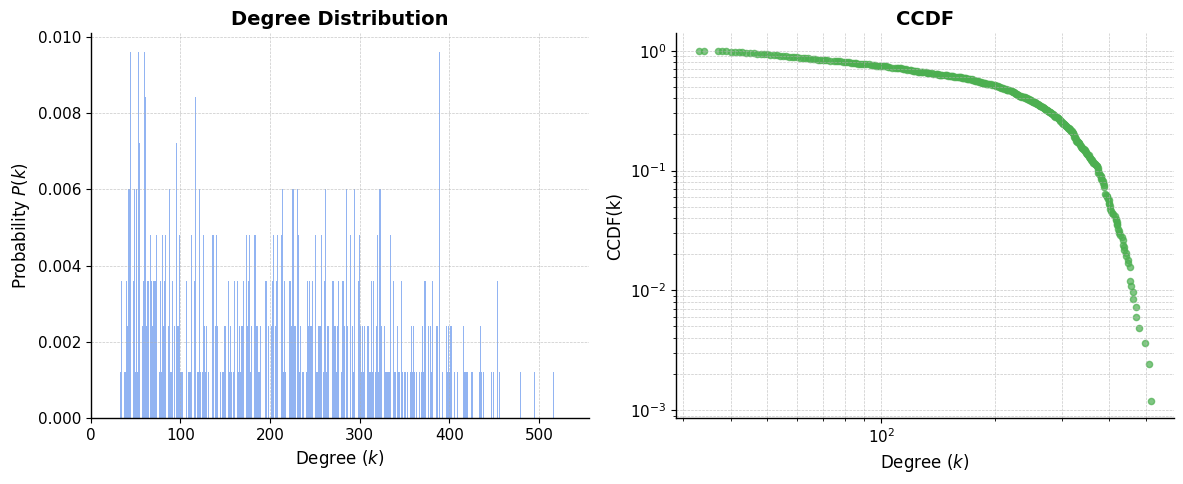

In [45]:
# General metrics
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()

# Degree metrics
degrees = [val for (node, val) in G.degree()]
avg_deg = np.mean(degrees)
min_deg = np.min(degrees)
max_deg = np.max(degrees)

# Average clustering and assortativity
avg_clust = nx.average_clustering(G)
assort = nx.degree_assortativity_coefficient(G)

# Path length and diameter
avg_path = nx.average_shortest_path_length(G)
diam = nx.diameter(G)

# Define dictionary
data = {
    "Metric": [
        "Nodes",
        "Edges",
        "Average Degree",
        "Min. Degree",
        "Max. Degree",
        "Avg. Clustering Coeffcient",
        "Assortativity",
        "Avg. Path Length",
        "Diameter",
    ],
    "Value": [
        f"{n_nodes:,.0f}",
        f"{n_edges:,.0f}",
        f"{avg_deg:.4f}",
        f"{min_deg:,.0f}",
        f"{max_deg:,.0f}",
        f"{avg_clust:.4f}",
        f"{assort:.4f}",
        f"{avg_path:.4f}",
        f"{diam:,.0f}",
    ],
}

# Create DataFrame
df_metrics = pd.DataFrame(data)

print(df_metrics)

# Get the degree sequence
degree_sequence = [G.degree(node) for node in G.nodes()]
degree_counts = Counter(degree_sequence)
n_nodes = G.number_of_nodes()

# Define k and P(k) for the linear distribution plot
k_values, k_counts = zip(*sorted(degree_counts.items()))
pk_probs = [c / n_nodes for c in k_counts]

# Get full degree count list
min_degree = min(degree_sequence)
max_degree = max(degree_sequence)

# Create full degree list and counts (including zeros)
degrees_all = list(range(min_degree, max_degree + 1))
degree_count_full = [degree_counts.get(k, 0) for k in degrees_all]

# Filter out zero counts for CCDF calculation
degrees_nz = np.array(
    [degrees_all[i] for i in range(len(degrees_all)) if degree_count_full[i] != 0]
)
degree_count_nz = np.array(
    [
        degree_count_full[i]
        for i in range(len(degree_count_full))
        if degree_count_full[i] != 0
    ]
)

# Get the CCDF
cdf = np.cumsum(degree_count_nz) / n_nodes
ccdf = np.ones(len(cdf)) - cdf

# Filter for log-log plot
mask = ccdf > 0
degrees_fit = degrees_nz[mask]
ccdf_fit = ccdf[mask]

# Generate plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Subplot 1: Degree Distribution P(k)
ax1 = axes[0]
ax1.bar(k_values, pk_probs, width=0.8, alpha=0.7, color="#6495ED")

# Customize Subplot 1
ax1.set_title("Degree Distribution")
ax1.set_xlabel("Degree ($k$)")
ax1.set_ylabel("Probability $P(k)$")
ax1.set_xlim(left=0)

# Subplot 2: CCDF (Log-Log Scale)
ax2 = axes[1]
ax2.scatter(degrees_fit, ccdf_fit, marker="o", s=20, alpha=0.7, color="#4CAF50")

# Customize Subplot 2
ax2.set_title("CCDF")
ax2.set_xlabel("Degree ($k$)")
ax2.set_ylabel("CCDF(k)")
ax2.set_xscale("log")
ax2.set_yscale("log")

# Save figure
plt.tight_layout()
plt.savefig("../images/degree_distribution.png")
plt.show()

### **2.2 Microscopic**

      Degree Node  Degree Species Degree Score  Betweenness Node  \
Rank                                                               
1             829              10       0.6378               234   
2             742               9       0.6209               638   
3             391               5       0.6125                64   
4             374               5       0.5957               178   
5             179               3       0.5764               571   

      Betweenness Species Betweenness Score  Eigenvector Node  \
Rank                                                            
1                       3            0.0173               742   
2                       8            0.0112               391   
3                       1            0.0103               829   
4                       3            0.0099               374   
5                       7            0.0096               345   

      Eigenvector Species Eigenvector Score  
Rank                 

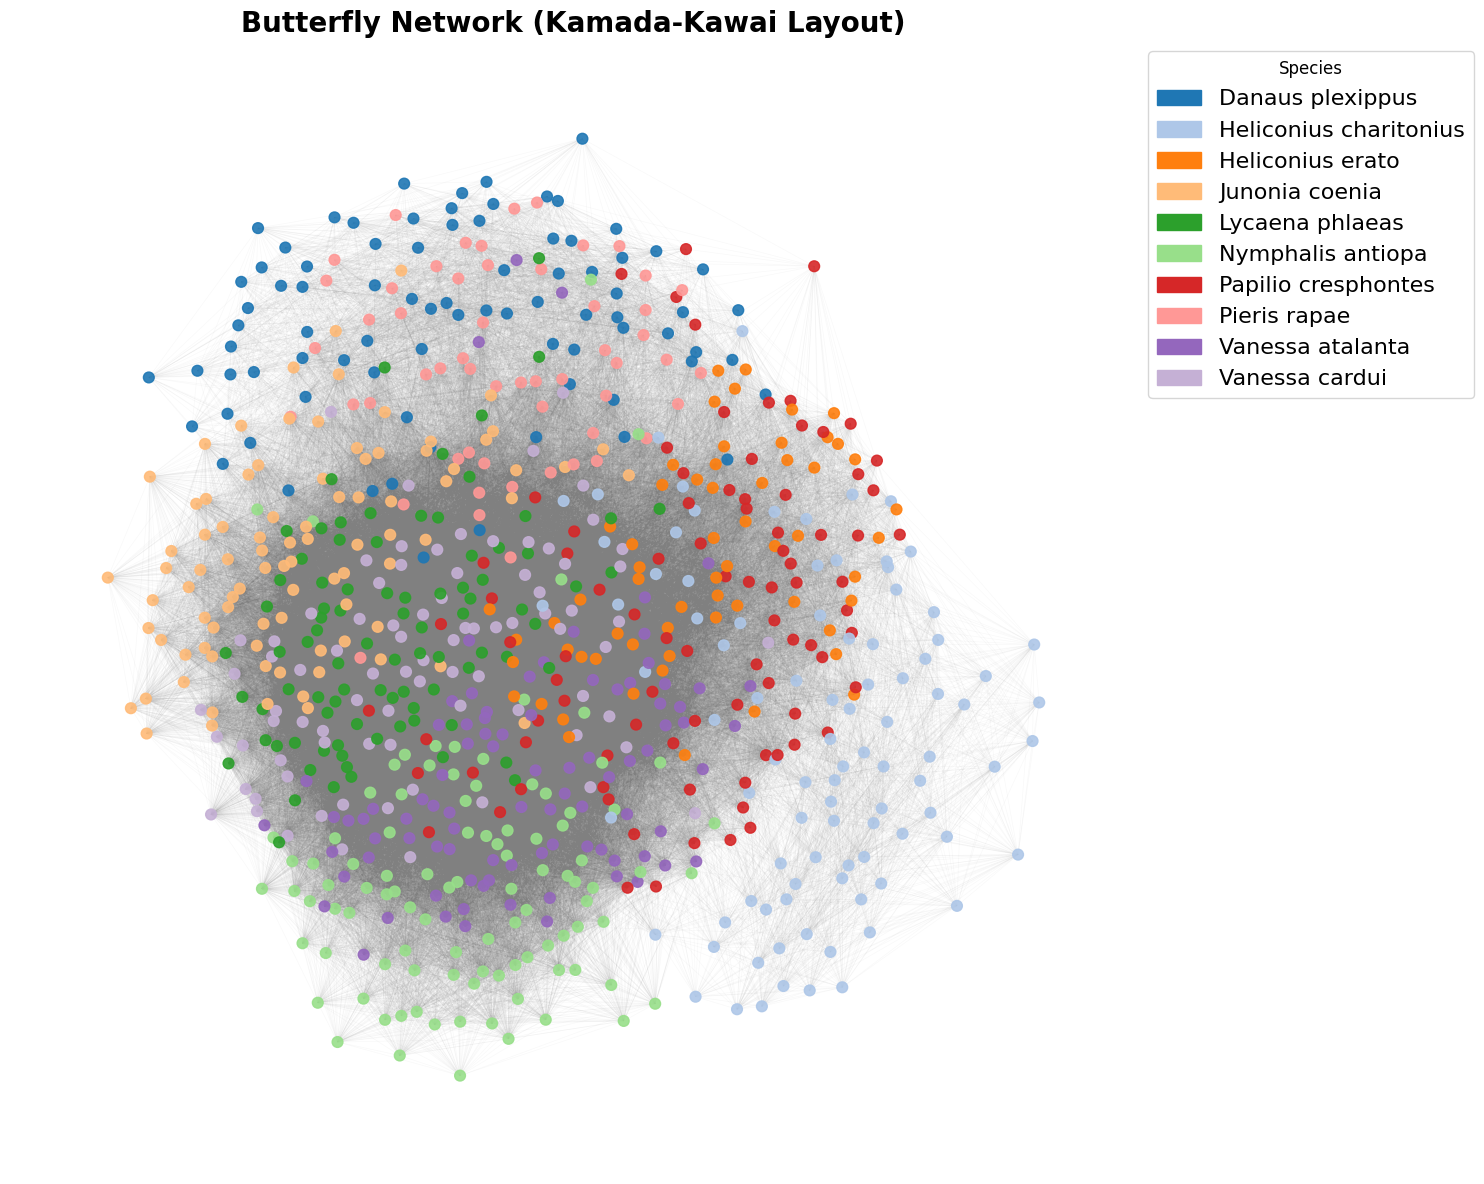

In [46]:
# Get the top 5 nodes for degree, betweenness, and eigenvector centrality measures
deg_cent = nx.degree_centrality(G)
bet_cent = nx.betweenness_centrality(G)
eig_cent = nx.eigenvector_centrality(G)

# Sort and get top 5 for each centrality measure
top_degree = sorted(deg_cent.items(), key=lambda item: item[1], reverse=True)[:5]
top_betweenness = sorted(bet_cent.items(), key=lambda item: item[1], reverse=True)[:5]
top_eigenvector = sorted(eig_cent.items(), key=lambda item: item[1], reverse=True)[:5]

# Unzip into (node, score) values
deg_nodes, deg_scores = zip(*top_degree)
bet_nodes, bet_scores = zip(*top_betweenness)
eig_nodes, eig_scores = zip(*top_eigenvector)

# Extract species for the selected nodes
deg_species = [G.nodes[n]["Species"] for n in deg_nodes]
bet_species = [G.nodes[n]["Species"] for n in bet_nodes]
eig_species = [G.nodes[n]["Species"] for n in eig_nodes]

# Create a single DataFrame with Species columns included
centrality_top5_df = pd.DataFrame(
    {
        "Rank": [1, 2, 3, 4, 5],
        "Degree Node": deg_nodes,
        "Degree Species": deg_species,
        "Degree Score": deg_scores,
        "Betweenness Node": bet_nodes,
        "Betweenness Species": bet_species,
        "Betweenness Score": bet_scores,
        "Eigenvector Node": eig_nodes,
        "Eigenvector Species": eig_species,
        "Eigenvector Score": eig_scores,
    }
).set_index("Rank")

# Format scores
centrality_top5_df["Degree Score"] = centrality_top5_df["Degree Score"].map(
    "{:.4f}".format
)
centrality_top5_df["Betweenness Score"] = centrality_top5_df["Betweenness Score"].map(
    "{:.4f}".format
)
centrality_top5_df["Eigenvector Score"] = centrality_top5_df["Eigenvector Score"].map(
    "{:.4f}".format
)

print(centrality_top5_df)

# Get species data for coloring
species_map = nx.get_node_attributes(G, "Species")
unique_species = sorted(list(set(species_map.values())))
species_to_idx = {s: i for i, s in enumerate(unique_species)}

# Assign colors using a colormap
cmap = plt.get_cmap("tab20")
node_colors = [cmap(species_to_idx[species_map[n]]) for n in G.nodes()]

# Calculate Kamada-Kawai layout
pos = nx.kamada_kawai_layout(G)

# Define figure
plt.figure(figsize=(15, 12))

# Draw Edges
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.05,
    edge_color="gray",
    width=0.5,
)

# Draw Nodes
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    node_size=60,
    alpha=0.9,
)

# Create legend
patches = [
    mpatches.Patch(color=cmap(i), label=species_names.get(s_id, f"Species {s_id}"))
    for i, s_id in enumerate(species_to_idx)
]
plt.legend(
    handles=patches,
    bbox_to_anchor=(1, 1),
    loc="upper left",
    title="Species",
    fontsize=16,
)

# Save figure
plt.title("Butterfly Network (Kamada-Kawai Layout)", fontsize=20)
plt.axis("off")
plt.tight_layout()
plt.savefig("../images/network_kamada_kawai.png")
plt.show()

## **3. Community Analysis**

### **3.1 Modularity Maximization: Louvain**

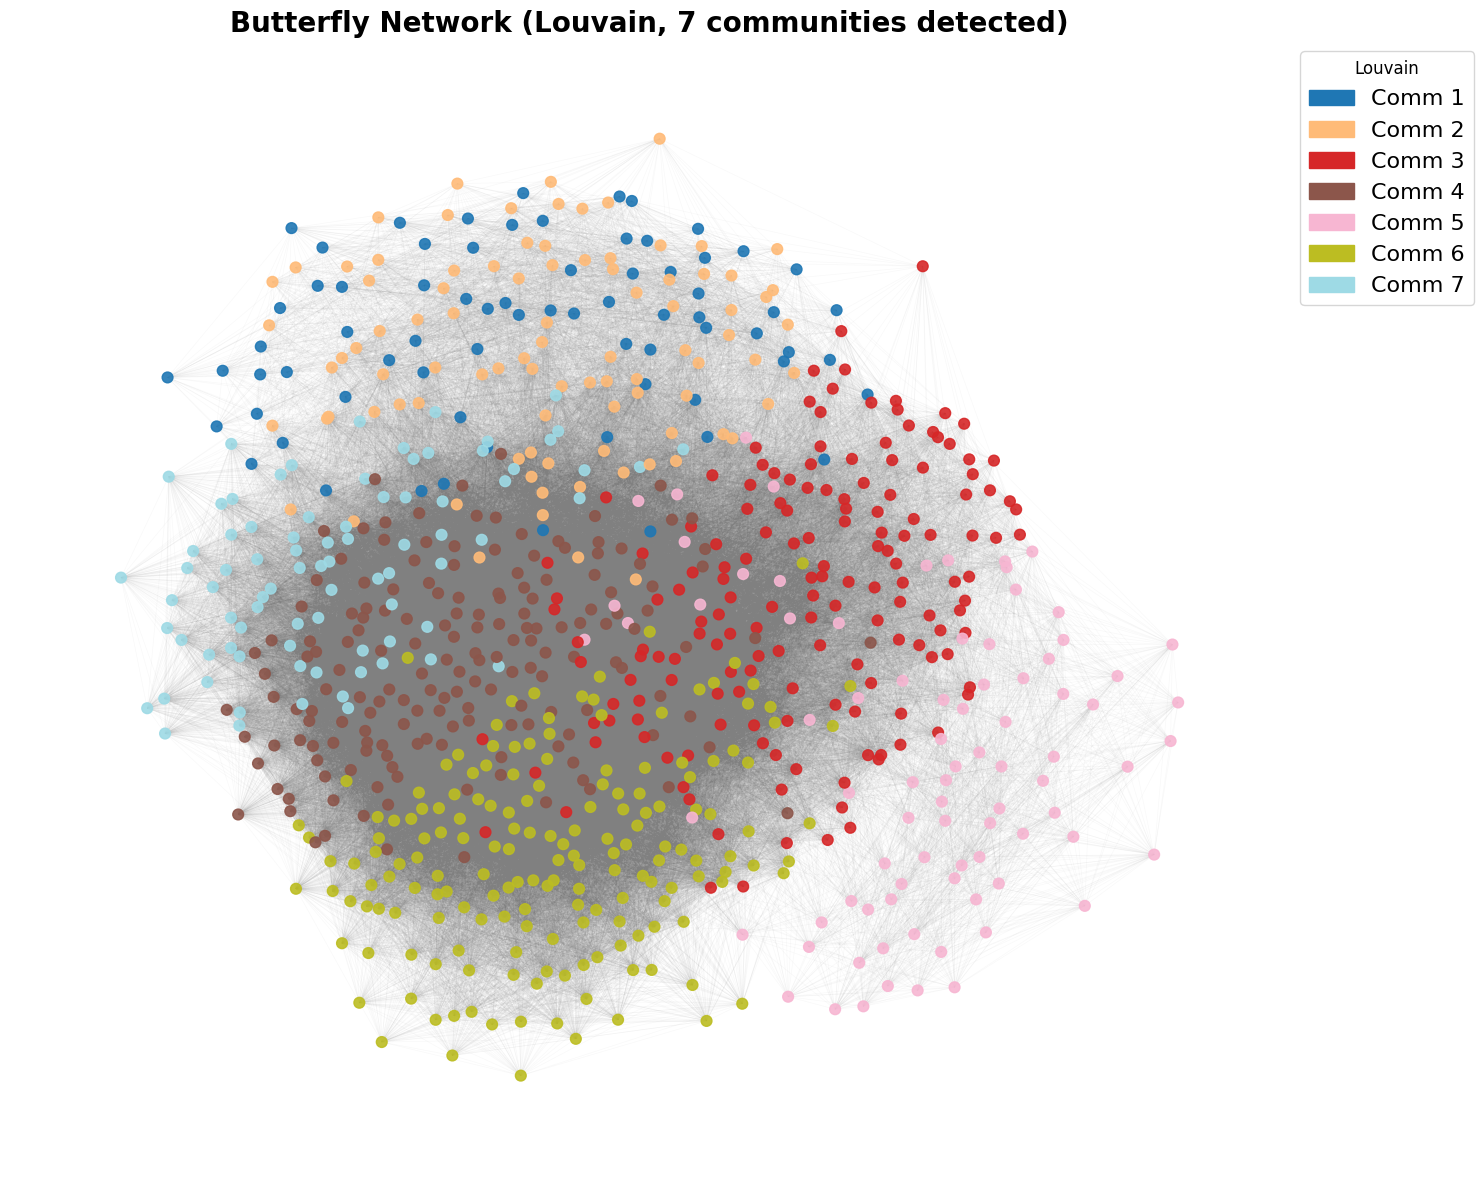

In [47]:
# Run Louvain algorithm
louvain_comms = nx_comm.louvain_communities(
    G,
    weight="Image similarity weight",
    seed=42,
)

# Convert list of sets to a node-to-community dictionary
partition = {}
for i, comm in enumerate(louvain_comms, start=1):
    for node in comm:
        partition[node] = i

# Add to graph attributes
nx.set_node_attributes(G, partition, "louvain_id")

# Define figure
plt.figure(figsize=(15, 12))

# Get community IDs for coloring
community_ids = [partition[n] for n in G.nodes()]
num_communities = len(louvain_comms)
unique_comms = sorted(list(set(community_ids)))

# Setup colormap
cmap = plt.get_cmap("tab20", num_communities)

# Draw Edges
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.05,
    edge_color="gray",
    width=0.5,
)

# Draw Nodes
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=community_ids,
    cmap=cmap,
    node_size=60,
    alpha=0.9,
)

# Add Legend
if num_communities <= 15:
    patches = [
        mpatches.Patch(
            color=cmap(i / max(1, num_communities - 1)), label=f"Comm {c_id}"
        )
        for i, c_id in enumerate(unique_comms)
    ]
    plt.legend(
        handles=patches,
        bbox_to_anchor=(1, 1),
        loc="upper left",
        title="Louvain",
        fontsize=16,
    )

# Save figure
plt.title(
    f"Butterfly Network (Louvain, {num_communities} communities detected)", fontsize=20
)
plt.axis("off")
plt.tight_layout()
plt.savefig("../images/network_kamada_kawai_louvain.png")
plt.show()

### **3.2 Stochastic Block Model (SBM)**

Run 1/15...
Description length: -18229.4912
New best description length: -18229.4912
Run 2/15...
Description length: -18522.5975
New best description length: -18522.5975
Run 3/15...
Description length: -17672.7722
Run 4/15...
Description length: -18073.5826
Run 5/15...
Description length: -18237.1589
Run 6/15...
Description length: -18109.5096
Run 7/15...
Description length: -18294.1960
Run 8/15...
Description length: -18149.1486
Run 9/15...
Description length: -18307.5623
Run 10/15...
Description length: -18270.9563
Run 11/15...
Description length: -18457.3837
Run 12/15...
Description length: -18130.8367
Run 13/15...
Description length: -17878.4110
Run 14/15...
Description length: -18166.7469
Run 15/15...
Description length: -18072.5897


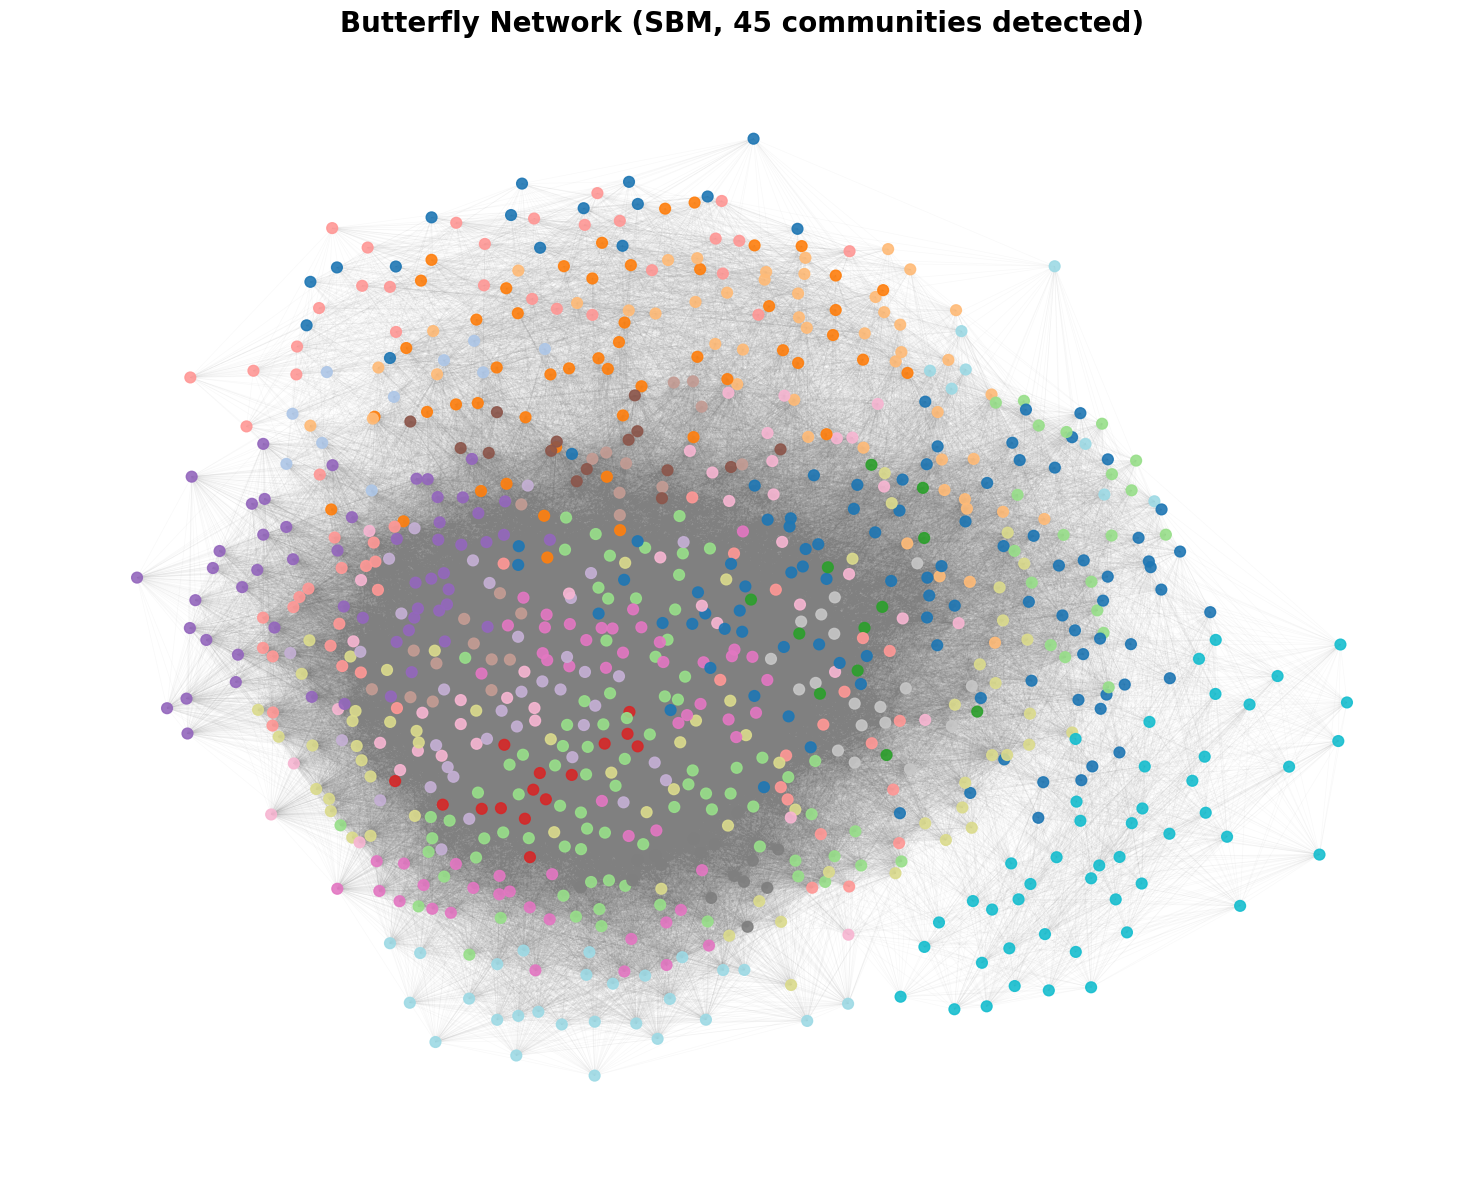

In [48]:
# Initialize empty Graph-tool graph
g_gt = gt.Graph(directed=G.is_directed())

# Create a property to take into account the weights
# https://graph-tool.skewed.de/static/docs/stable/demos/inference/inference.html
eweight = g_gt.new_edge_property("double")

# Dictionary to map NetworkX Node IDs -> Graph-tool Vertex Objects
vmap = {}

# Add nodes
for node in G.nodes():
    vmap[node] = g_gt.add_vertex()

# Add edges and assign weights
for u, v, data in G.edges(data=True):
    e = g_gt.add_edge(vmap[u], vmap[v])
    eweight[e] = data.get("Image similarity weight")

# Initialize
best_state = None
best_dl = float("inf")

# Perform multiple SBM inferences to find the best model
for i in range(15):
    # Display progress
    print(f"Run {i+1}/15...")
    state = gt.minimize_blockmodel_dl(
        g_gt, state_args=dict(recs=[eweight], rec_types=["real-exponential"])
    )

    # Compute description length
    dl = state.entropy()
    print(f"Description length: {dl:.4f}")

    # Update best model if necessary
    if dl < best_dl:
        best_dl = dl
        best_state = state
        print(f"New best description length: {best_dl:.4f}")

# Map SBM Blocks back to NetworkX
gt_blocks = best_state.get_blocks()
sbm_assignments = {}

# Assign SBM block IDs to NetworkX nodes
for nx_node, gt_vertex in vmap.items():
    sbm_assignments[nx_node] = gt_blocks[gt_vertex]

# Set SBM block as node attribute in NetworkX graph
nx.set_node_attributes(G, sbm_assignments, "sbm_block")

# Define figure
plt.figure(figsize=(15, 12))

# Get community IDs for coloring
community_ids = [G.nodes[n]["sbm_block"] for n in G.nodes()]
unique_communities = sorted(list(set(community_ids)))
num_communities = len(unique_communities)

# Setup colormap
cmap = plt.get_cmap("tab20", num_communities)

# Draw Edges
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.05,
    edge_color="gray",
    width=0.5,
)

# Draw Nodes
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=community_ids,
    cmap=cmap,
    node_size=60,
    alpha=0.9,
)

# Add Legend
if num_communities <= 15:
    patches = [
        mpatches.Patch(
            color=cmap(i / max(1, num_communities - 1)), label=f"Comm {c_id}"
        )
        for i, c_id in enumerate(unique_communities)
    ]
    plt.legend(
        handles=patches,
        bbox_to_anchor=(1, 1),
        loc="upper left",
        title="SBM",
        fontsize=16,
    )

# Save figure
plt.title(
    f"Butterfly Network (SBM, {num_communities} communities detected)",
    fontsize=20,
)
plt.axis("off")
plt.tight_layout()
plt.savefig("../images/network_kamada_kawai_sbm.png")
plt.show()

### **3.3 Infomap**

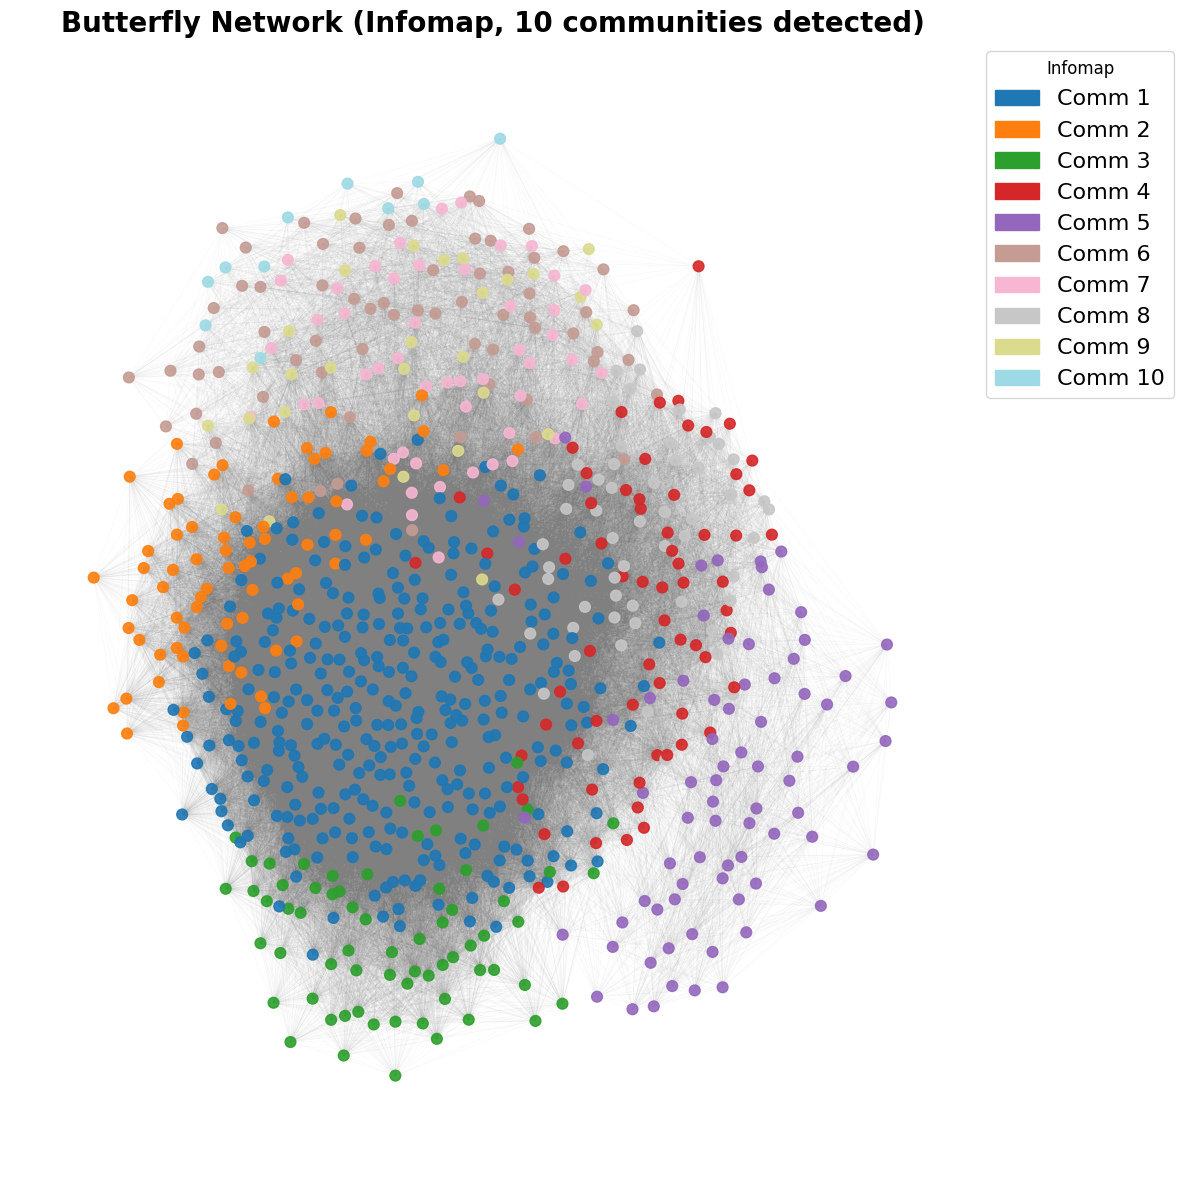

In [49]:
# Run infomap algorithm with weights
im = infomap.Infomap(silent=True, two_level=True, seed=42)

# Iterate over edges with data to get the weight
for u, v, data in G.edges(data=True):
    w = data.get("Image similarity weight")
    im.add_link(u, v, w)

# Infomap
im.run()

# Extract communities
communities = im.get_modules()
nx.set_node_attributes(G, communities, "community_id")

# Define figure
plt.figure(figsize=(12, 12))

# Get the list of community IDs for every node
community_ids = [G.nodes[n]["community_id"] for n in G.nodes()]
unique_communities = sorted(list(set(community_ids)))
num_communities = len(unique_communities)

# Setup colormap
cmap = plt.get_cmap("tab20", num_communities)

# Draw Edges
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.05,
    edge_color="gray",
    width=0.5,
)

# Draw Nodes
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=community_ids,
    cmap=cmap,
    node_size=60,
    alpha=0.9,
)

# Add Legend
if num_communities <= 15:
    patches = [
        mpatches.Patch(
            color=cmap(i / max(1, num_communities - 1)), label=f"Comm {c_id}"
        )
        for i, c_id in enumerate(unique_communities)
    ]
    plt.legend(
        handles=patches,
        bbox_to_anchor=(1, 1),
        loc="upper left",
        title="Infomap",
        fontsize=16,
    )

# Save figure
plt.title(
    f"Butterfly Network (Infomap, {num_communities} communities detected)",
    fontsize=20,
)
plt.axis("off")
plt.tight_layout()
plt.savefig("../images/network_kamada_kawai_infomap.png")
plt.show()

## **4. Discussion**

### **4.1 Louvain Confusion Matrix**

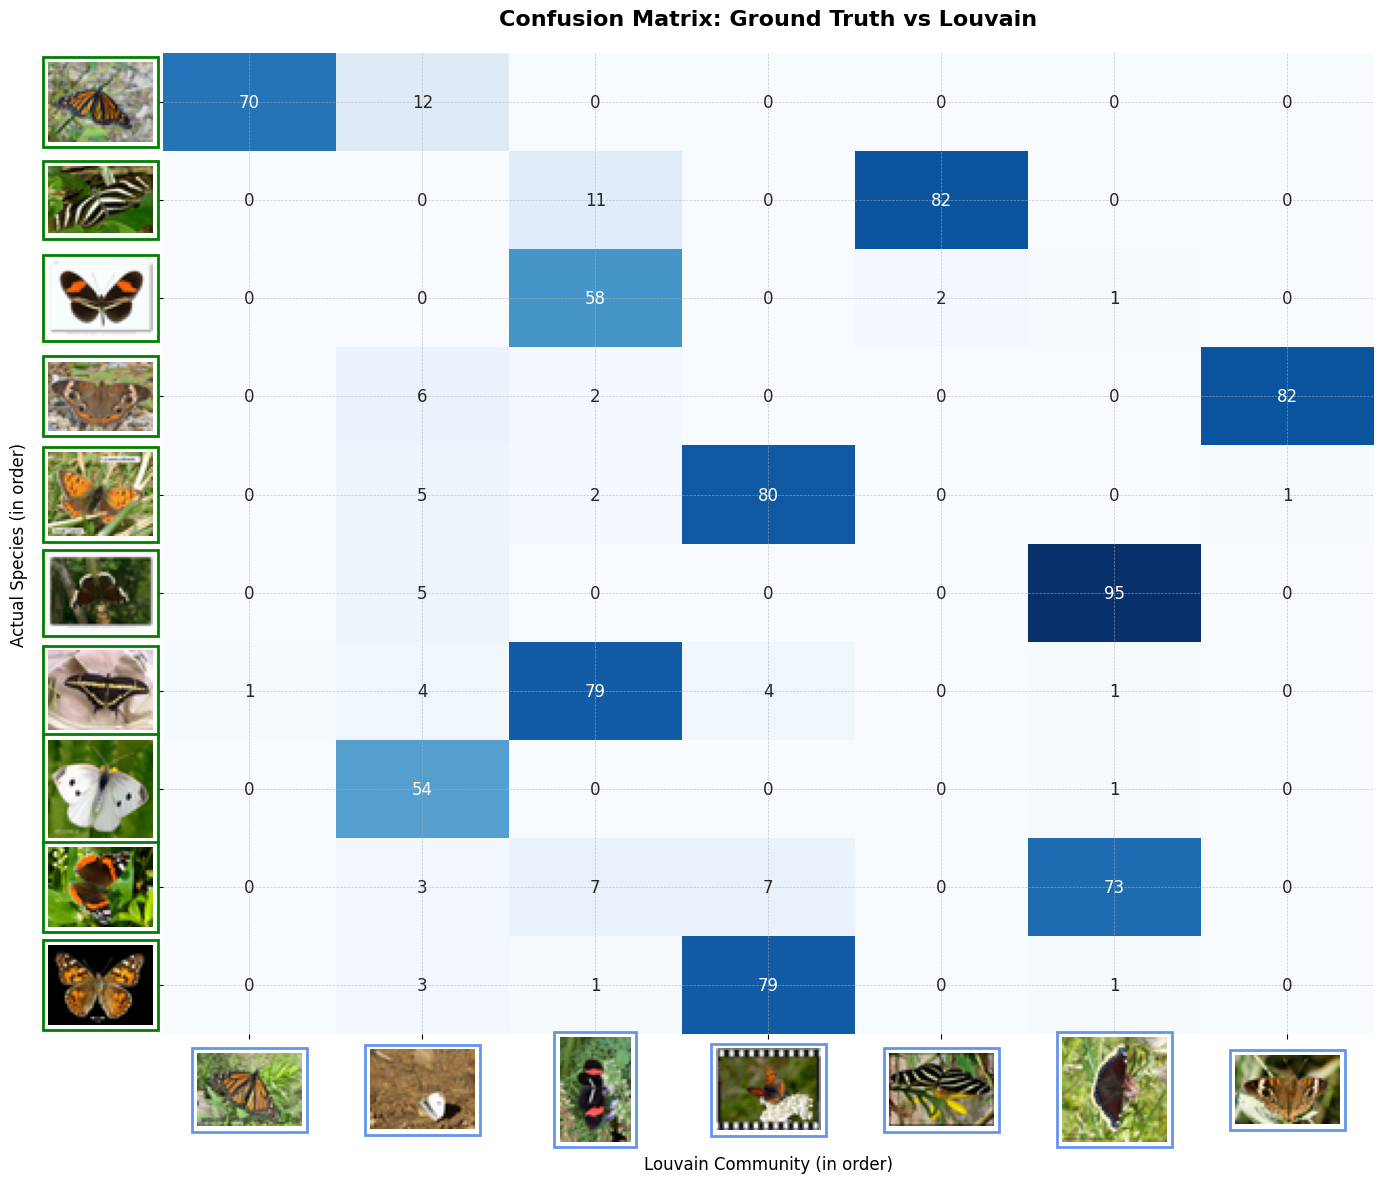

In [50]:
# Setup data root and image directory
data_root = "../data/leedsbutterfly"
img_dir = os.path.join(data_root, "images")

# Get file list and map nodes to files
all_images = sorted(glob.glob(os.path.join(img_dir, "*.png")))
node_to_file = {i: f for i, f in enumerate(all_images)}

# Get representatives for species axis (y-axis)
species_representatives = {}
for img_path in all_images:
    # Extract category ID from filename
    fname = os.path.basename(img_path)
    cat_id = int(fname[:3])

    # Pick the first one we encounter for each category
    if cat_id not in species_representatives and cat_id in species_names:
        species_representatives[cat_id] = img_path

# Calculate Community Leaders for community axis (x-axis)
partition = nx.get_node_attributes(G, "louvain_id")
comm_groups = defaultdict(list)

# Group nodes by their community
for node, comm_id in partition.items():
    comm_groups[comm_id].append(node)
    
# Preallocate 
comm_leaders = {}

# Find the leaders of each community
for comm_id, nodes in comm_groups.items():
    # Create a subgraph of ONLY nodes in this community
    subgraph = G.subgraph(nodes)
    
    # Calculate Degree Centrality for the subgraph
    d_centrality = nx.degree_centrality(subgraph)
    
    # Find the node with the highest centrality score
    leader_node = max(nodes, key=lambda n: d_centrality[n])
    comm_leaders[comm_id] = leader_node

# Prepare Heatmap Data
node_data = []
for n in G.nodes():
    node_data.append(
        {
            "node": n,
            "species_id": G.nodes[n]["Species"],
            "louvain_comm": G.nodes[n]["louvain_id"],
        }
    )

# Create DataFrame for confusion matrix
df = pd.DataFrame(node_data)
df["species_name"] = df["species_id"].map(species_names)
confusion_matrix = pd.crosstab(df["species_name"], df["louvain_comm"])

# Plotting
fig, ax = plt.subplots(figsize=(14, 12))
plt.subplots_adjust(bottom=0.2, left=0.2)

# Draw Heatmap
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

# Remove standard axis text labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Set labels
ax.set_xlabel("Louvain Community (in order)", fontsize=12, labelpad=80)
ax.set_ylabel("Actual Species (in order)", fontsize=12, labelpad=90)
ax.set_title("Confusion Matrix: Ground Truth vs Louvain", fontsize=16, y=1.02)


# Load image array
# https://github.com/has2k1/plotnine/issues/817
def get_image_array(path):
    img = Image.open(path).convert("RGB")
    img.thumbnail((50, 50), Image.Resampling.LANCZOS)
    return np.array(img)


# Place Images on X-Axis (Communities)
for i, comm_id in enumerate(confusion_matrix.columns):
    # Get leader image directly
    node_id = comm_leaders[comm_id]
    img_arr = get_image_array(node_to_file[node_id])

    # Get image box
    imagebox = OffsetImage(img_arr, zoom=1.5)
    imagebox.image.axes = ax

    # Create annotation box as axis label
    ab = AnnotationBbox(
        imagebox,
        (i + 0.5, len(confusion_matrix)),
        xybox=(0, -40),
        xycoords="data",
        boxcoords="offset points",
        frameon=True,
        bboxprops=dict(edgecolor="#6495ED", linewidth=2),
    )
    ax.add_artist(ab)

# Place Images on Y-Axis (Species)
for j, species_name in enumerate(confusion_matrix.index):
    # Get species representative directly
    species_id = next(k for k, v in species_names.items() if v == species_name)
    img_arr = get_image_array(species_representatives[species_id])

    # Get image box
    imagebox = OffsetImage(img_arr, zoom=1.5)
    imagebox.image.axes = ax

    # Create annotation box as axis label
    ab = AnnotationBbox(
        imagebox,
        (0, j + 0.5),
        xybox=(-45, 0),
        xycoords="data",
        boxcoords="offset points",
        frameon=True,
        bboxprops=dict(edgecolor="green", linewidth=2),
    )
    ax.add_artist(ab)

# Save figure
plt.savefig("../images/louvain_confusion_matrix.png")
plt.show()

### **4.2 Species Distribution**

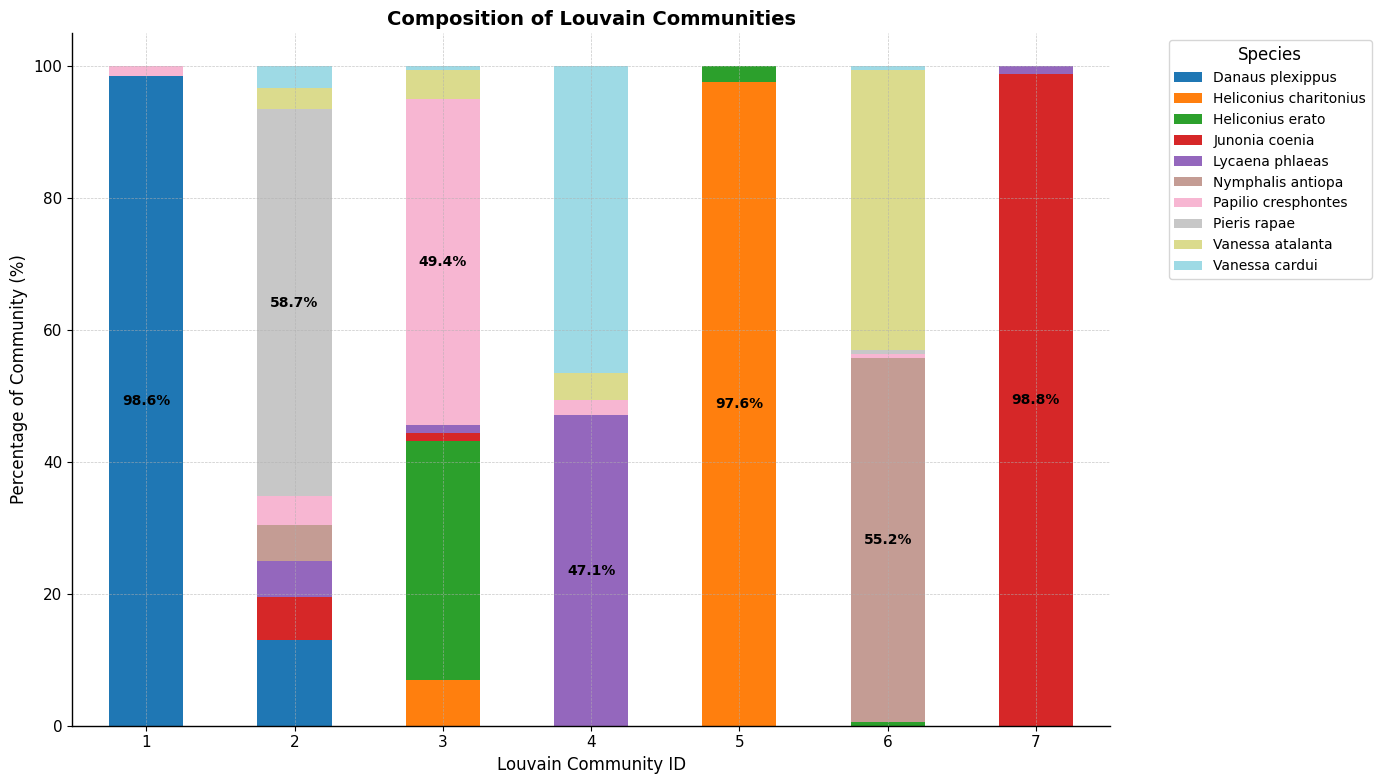

In [51]:
# Create count tables
crosstab = pd.crosstab(df["louvain_comm"], df["species_name"])

# Divide each row by the row sum so it adds up to 100%
crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

# Plot
ax = crosstab_norm.plot(kind="bar", stacked=True, figsize=(14, 8), colormap="tab20")

# Iterate through each community
for i, (comm_id, row) in enumerate(crosstab_norm.iterrows()):
    # Find the species with the highest percentage
    dominant_species = row.idxmax()
    purity_pct = row.max()

    # Find column index
    col_idx = crosstab_norm.columns.get_loc(dominant_species)

    # Get the specific bar patch
    bar = ax.containers[col_idx][i]

    # Calculate center position
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_y() + bar.get_height() / 2

    # Add text
    ax.text(
        x,
        y,
        f"{purity_pct:.1f}%",
        ha="center",
        va="center",
        color="black",
        fontweight="bold",
        fontsize=10,
    )

# Customize
plt.title("Composition of Louvain Communities")
plt.xlabel("Louvain Community ID")
plt.ylabel("Percentage of Community (%)")
plt.legend(title="Species", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)

# Save figure
plt.tight_layout()
plt.savefig("../images/species_distribution_across_communities.png")
plt.show()

### **4.3 Dendogram Analysis**

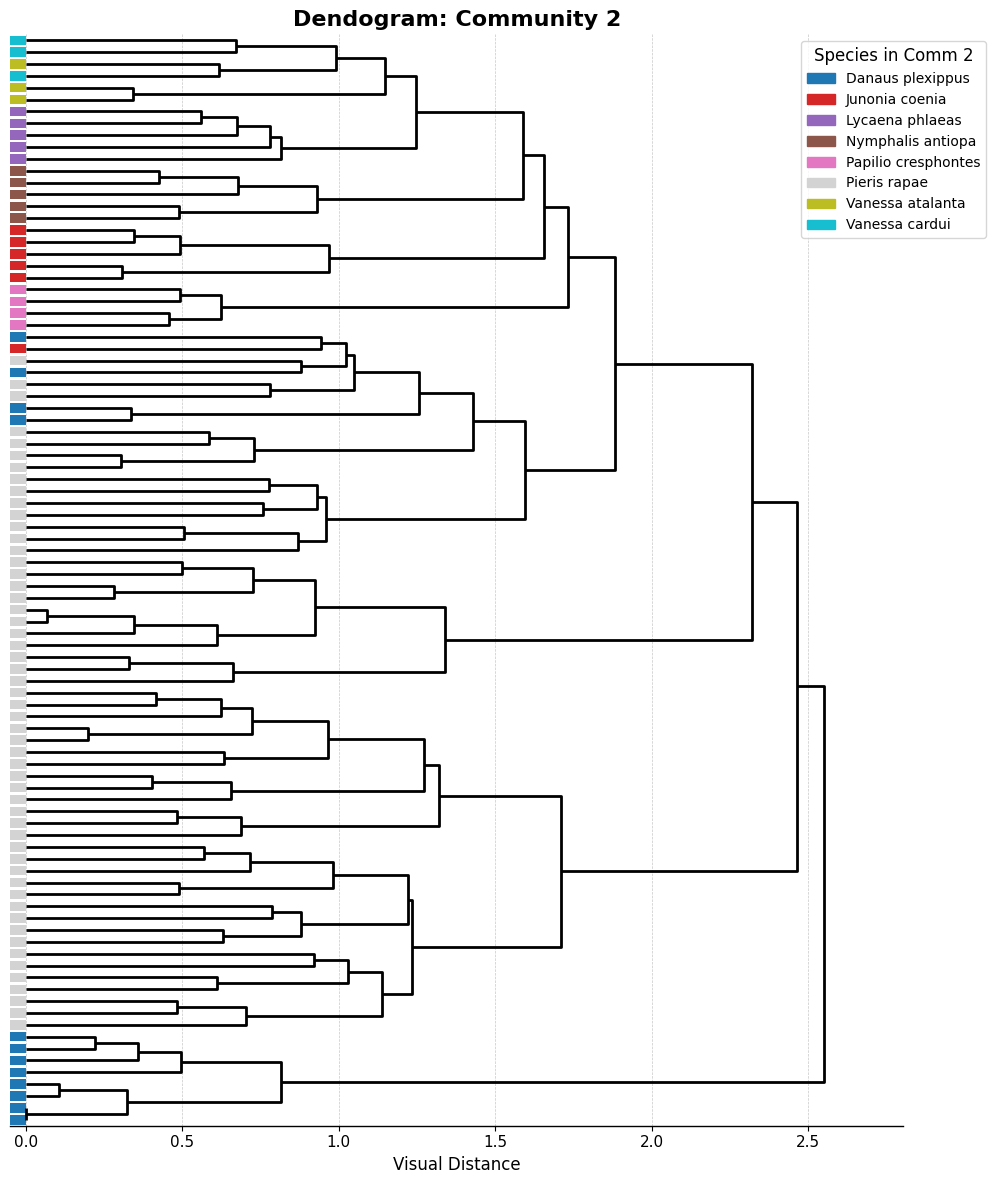

In [52]:
# Study for community 2
target_comm_id = 2

# Colormap consistency
cmap = plt.get_cmap('tab10')
species_colors = {}
for i in range(1, 11):
    if i == 8:
        species_colors[i] = "#D3D3D3" 
    else:
        species_colors[i] = cmap(i-1)

# Get nodes
nodes = [n for n, c in partition.items() if c == target_comm_id]
subG = G.subgraph(nodes)

# Calculate Distance Matrix
# https://stackoverflow.com/questions/77691074/clustering-data-using-scipy-and-a-distance-matriz-in-python
sim_matrix = nx.to_numpy_array(subG, nodelist=nodes, weight='Image similarity weight')
if sim_matrix.max() > 0:
    sim_matrix = sim_matrix / sim_matrix.max()
dist_matrix = 1.0 - sim_matrix
np.fill_diagonal(dist_matrix, 0)
condensed_dist = squareform(dist_matrix)
Z = linkage(condensed_dist, method='ward')

# Define figure
fig, ax = plt.subplots(figsize=(10, 12))

# Plot Dendrogram
ddata = dendrogram(
    Z,
    ax=ax,
    orientation='left',
    no_labels=True,
    link_color_func=lambda k: 'black', 
)

# Fix labels on y-axis
ordered_indices = ddata['leaves']
present_species = set()

for i, idx in enumerate(ordered_indices):
    # Get info
    node_id = nodes[idx]
    sp_id = G.nodes[node_id]['Species']
    present_species.add(sp_id)

    # Set color
    color = species_colors.get(sp_id)
    
    # Align bar
    y_pos = 5 + i * 10

    # Show species as rectangles
    rect = mpatches.Rectangle(
        (0, y_pos - 4), 
        -0.05, 
        8, 
        facecolor=color,
        edgecolor='none'
    )
    ax.add_patch(rect)

# Customize
ax.set_xlim(-0.05, max(Z[:, 2]) * 1.1)
ax.set_yticks([]) 
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Visual Distance")
plt.title(f"Dendogram: Community {target_comm_id}", fontsize=16)

# Add legend
handles = []
sorted_present = sorted(list(present_species))
for sp_id in sorted_present:
    handles.append(mpatches.Patch(color=species_colors[sp_id], label=species_names[sp_id]))
plt.legend(handles=handles, title="Species in Comm 2", loc='upper right', bbox_to_anchor=(1.1, 1))

# Save figure
plt.tight_layout()
plt.savefig(f'../images/dendogram_comm_{target_comm_id}.png')
plt.show()